In [1]:
import numpy as np
import matplotlib.pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from scipy.integrate import solve_ivp

from ode_sys import *

from SALib.sample import saltelli
from SALib.sample import morris as morris_s
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

# Data

In [2]:
# invented data for a and m
t_in = np.array([    3,    6,    9,   10,   11,    12,   14,   16,   18,   20,   22,   24,   26,   28,   30,   32])
y_in = np.array([ .023,  .09,  .36,  .59,  .98,  1.19, 1.41, 1.64, 2.24, 2.56, 3.24, 4.13, 5.02, 5.09, 5.23, 5.28])
a_in = np.array([.0046, .018, .072, .118, .196,  .238,  .28,  .41,  .88, 1.28, 2.11,  2.9,  3.5,  3.5,  3.4,  3.2])
m_in = np.array([.0207, .081, .324, .531, .882, 1.071, 1.27, 1.48, 1.98, 2.18, 2.55,  2.9,  3.2,  3.1,  2.9, 2.64])
# data when the cell is not starving (s=0)
t0_in = t_in[:7]
y0_in = y_in[:7]
a0_in = a_in[:7]
m0_in = m_in[:7]
data0_in = np.array([t0_in, y0_in, a0_in, m0_in])
# data when glucose is depleted -> starvation (s=1)
t1_in = t_in[6:]
y1_in = y_in[6:]
a1_in = a_in[6:]
m1_in = m_in[6:]

# starvation-data derived with the single cell model
# starvation
t1_sc = np.array([  14,   16,   18,   20,   22,   24,   26,   28,   30,   32])
y1_sc = np.array([1.41, 1.64, 2.24, 2.56, 3.24, 4.13, 5.02, 5.09, 5.23, 5.28])
a1_sc = np.array([ .28,  .42,  .69,  .92, 1.30, 1.81, 2.34, 2.46, 2.59, 2.64])
m1_sc = np.array([1.27, 1.41, 1.85, 2.03, 2.49, 3.08, 3.64, 3.59, 3.60, 3.55])
data1_sc = np.array([t1_sc, y1_sc, a1_sc, m1_sc])
# whole data
t_sc = np.concatenate((t0_in, t1_sc[1:]), axis=0)
y_sc = np.concatenate((y0_in, y1_sc[1:]), axis=0)
a_sc = np.concatenate((a0_in, a1_sc[1:]), axis=0)
m_sc = np.concatenate((m0_in, m1_sc[1:]), axis=0)

# Sobol

In [4]:
problem = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.346, .382],[50.35, 55.65],[.613, .645],[5.70, 6.1],[9.0, 9.614],
               [.190, .2],[.092, .098]]
}

param_values = saltelli.sample(problem, 700, calc_second_order=False)

In [5]:
rss = np.zeros((param_values.shape[0],3))

# for x01 see also "fitting.ipynb"
x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values):
    rss[i] = comp_rss(m_1l, t1_sc, x01, par, data1_sc[1:,:])

In [6]:
Siy = sobol.analyze(problem, rss[:,0], calc_second_order=False)
Sia = sobol.analyze(problem, rss[:,1], calc_second_order=False)
Sim = sobol.analyze(problem, rss[:,2], calc_second_order=False)

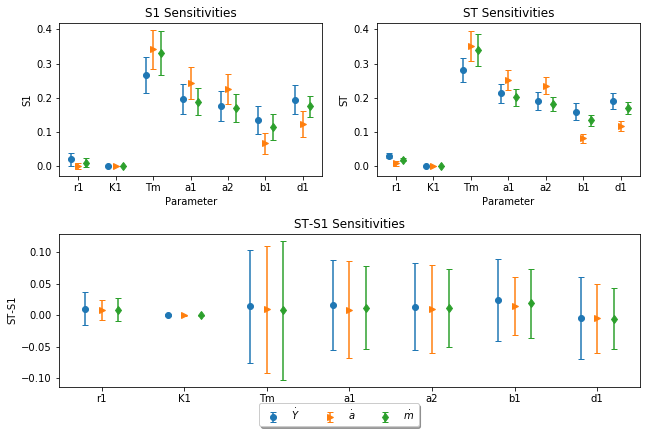

In [7]:
labels = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
sobol_plots(Siy, Sia, Sim, labels)#, True, 'sens_s1_st.pdf')

# Morris

In [8]:
problem_m = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.355, .37],[52.5, 53.5],[.61, .647],[5.80, 6.03],[9.1, 9.61],
               [.19, .1995],[.0927, .10]]
}

param_values_m = morris_s.sample(problem_m, 1000, 8)

In [11]:
rss_m = np.zeros((param_values_m.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values_m):
    rss_m[i] = comp_rss(m_1l, t1_sc, x01, par, data1_sc[1:,:])

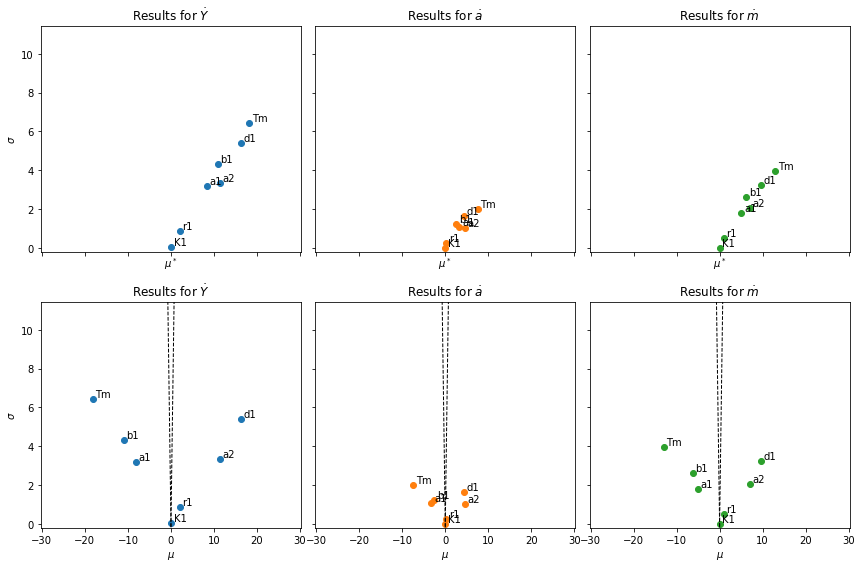

In [12]:
Siy_m = morris.analyze(problem_m, param_values_m, rss_m[:,0])
Sia_m = morris.analyze(problem_m, param_values_m, rss_m[:,1])
Sim_m = morris.analyze(problem_m, param_values_m, rss_m[:,2])

labels = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
morris_plot(Siy_m, Sia_m, Sim_m, labels)#, True, 'sens_mu_sig.pdf')

# Same plots for the other modifications

## Gen. log. growth

### Sobol

In [13]:
problem1 = {
    'num_vars': 8,
    'names': ['r1', 'n1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.740, .802], [1.810, 2.001], [55.10, 60.90],[.629, .663],
               [19.01, 20.10], [35.75, 37.79], [.193, .206],[.080, .086]]
}

param_values1 = saltelli.sample(problem1, 700, calc_second_order=False)

In [14]:
rss1 = np.zeros((param_values1.shape[0],3))

x01g = [1.3995981480119983, 0.2788898680560751, 1.186228590939174]
for i, par in enumerate(param_values1):
    rss1[i] = comp_rss(m_1g, t1_sc, x01g, par, data1_sc[1:,:])

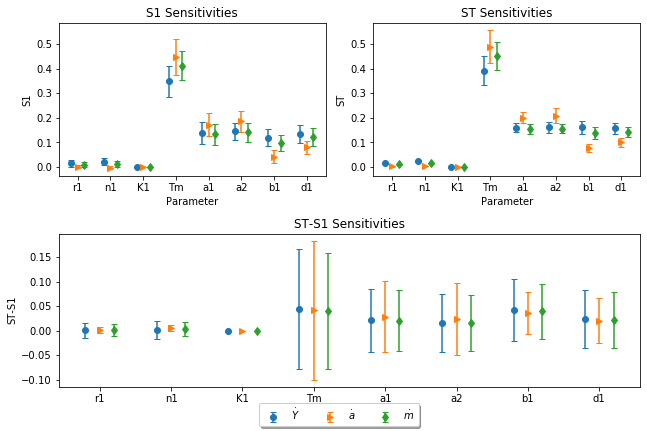

In [15]:
Siy1 = sobol.analyze(problem1, rss1[:,0], calc_second_order=False)
Sia1 = sobol.analyze(problem1, rss1[:,1], calc_second_order=False)
Sim1 = sobol.analyze(problem1, rss1[:,2], calc_second_order=False)

labels1 = ['r1', 'n1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
sobol_plots(Siy1, Sia1, Sim1, labels1)#, True, 'sens1_s1_st.pdf')

### Morris

In [16]:
problem_m1 = {
    'num_vars': 8,
    'names': ['r1', 'n1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.742, .802],[1.810, 1.935], [55.10, 60.90],[.629, .6619],
               [19.01, 20.1], [35.50, 37.79], [.193, .205],[.081, .086]]
}

param_values_m1 = morris_s.sample(problem_m1, 1000, 8)

In [17]:
rss_m1 = np.zeros((param_values_m1.shape[0],3))

x01g = [1.3995981480119983, 0.2788898680560751, 1.186228590939174]
for i, par in enumerate(param_values_m1):
    rss_m1[i] = comp_rss(m_1g, t1_sc, x01g, par, data1_sc[1:,:])

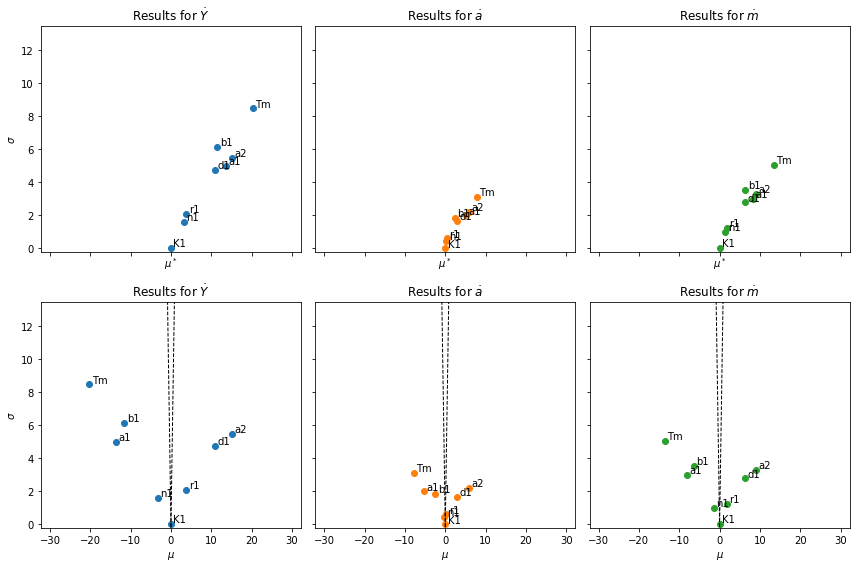

In [18]:
Siy_m1 = morris.analyze(problem_m1, param_values_m1, rss_m1[:,0])
Sia_m1 = morris.analyze(problem_m1, param_values_m1, rss_m1[:,1])
Sim_m1 = morris.analyze(problem_m1, param_values_m1, rss_m1[:,2])

labels1 = ['r1', 'n1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
morris_plot(Siy_m1, Sia_m1, Sim_m1, labels1)#, True, 'sens1_mu_sig.pdf')

## First mod. of $\dot m$ (with adaption)

### Sobol

In [19]:
#no adaption of the 5% variations needed
problem2 = {
    'num_vars': 8,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1', 'Ty'],
    'bounds': [[4.304, 4.757], [4.898, 5.414],[.638, .706], [.895, .989],
               [1.651, 1.825], [2.077, 2.295],[.024, .026], [.693, .766]]
}

#compute sec. order, since ST-S1 exceeds .3
param_values2 = saltelli.sample(problem2, 700, calc_second_order=True)

In [21]:
rss2 = np.zeros((param_values2.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values2):
    rss2[i] = comp_rss(m_1d2, t1_sc, x01, par, data1_sc[1:,:])

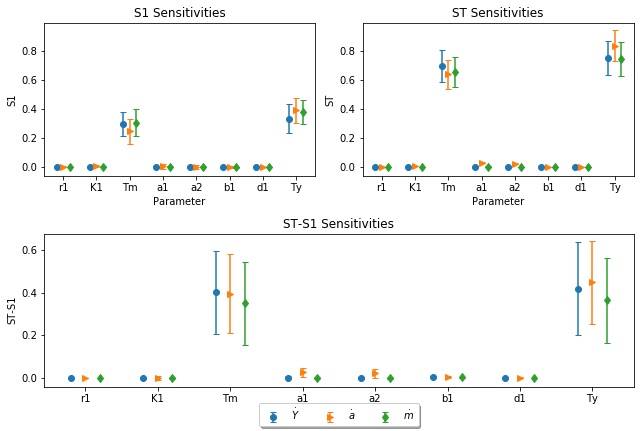

In [22]:
Siy2 = sobol.analyze(problem2, rss2[:,0], calc_second_order=True)
Sia2 = sobol.analyze(problem2, rss2[:,1], calc_second_order=True)
Sim2 = sobol.analyze(problem2, rss2[:,2], calc_second_order=True)

labels2 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1', 'Ty']
sobol_plots(Siy2, Sia2, Sim2, labels2)#, True, 'sens2_s1_st.pdf')

In [23]:
print('S2 value of Tm and Ty for Y: ' + str(Siy2['S2'][2, 7]))
print('Confidence interval for Y: ' + str(Siy2['S2_conf'][2, 7]))
print('S2 value of Tm and Ty for a: ' + str(Sia2['S2'][2, 7]))
print('Confidence interval for a: ' + str(Sia2['S2_conf'][2, 7]))
print('S2 value of Tm and Ty for m: ' + str(Sim2['S2'][2, 7]))
print('Confidence interval for m: ' + str(Sim2['S2_conf'][2, 7]))

S2 value of Tm and Ty for Y: 0.4255713876746143
Confidence interval for Y: 0.19112034608445855
S2 value of Tm and Ty for a: 0.39088358891272473
Confidence interval for a: 0.15332848652262784
S2 value of Tm and Ty for m: 0.3720463068266339
Confidence interval for m: 0.17117563454880785


### Morris

In [3]:
#5% variation
problem_m2 = {
    'num_vars': 8,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1', 'Ty'],
    'bounds': [[4.304, 4.757], [4.898, 5.414],[.638, .706], [.895, .989],
               [1.651, 1.825], [2.077, 2.295],[.024, .026], [.693, .766]]
}

param_values_m2 = morris_s.sample(problem_m2, 1000, 8)    

In [4]:
rss_m2 = np.zeros((param_values_m2.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values_m2):
    rss_m2[i] = comp_rss(m_1d2, t1_sc, x01, par, data1_sc[1:,:])

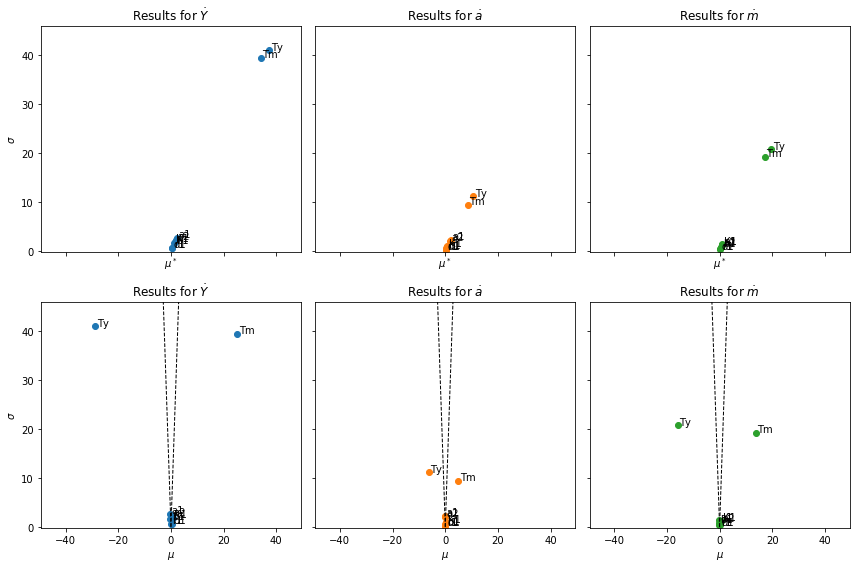

In [26]:
Siy_m2 = morris.analyze(problem_m2, param_values_m2, rss_m2[:,0])
Sia_m2 = morris.analyze(problem_m2, param_values_m2, rss_m2[:,1])
Sim_m2 = morris.analyze(problem_m2, param_values_m2, rss_m2[:,2])

labels2 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1', 'Ty']
morris_plot(Siy_m2, Sia_m2, Sim_m2, labels2)#, True, 'sens2_mu_sig.pdf')

## Second mod. of $\dot m$

### Sobol

In [27]:
#5% variation
problem3 = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.958, 1.059], [38.767, 42.848],[.615, .680], [3.061, 3.383],
               [4.671, 5.162], [1.528, 1.689],[.712, .787]]
}

param_values3 = saltelli.sample(problem3, 700, calc_second_order=True)

In [28]:
rss3 = np.zeros((param_values3.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values3):
    rss3[i] = comp_rss(m_1y, t1_sc, x01, par, data1_sc[1:,:])

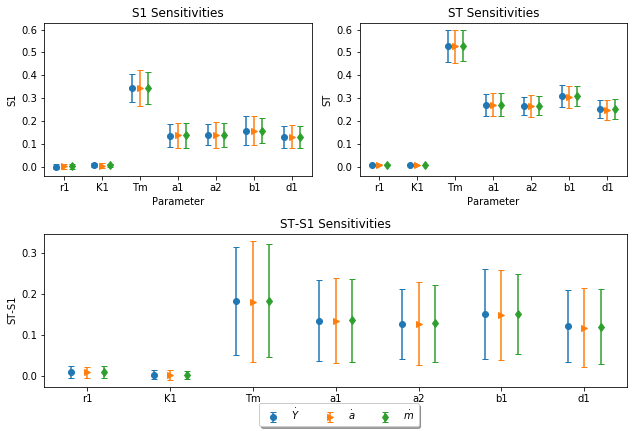

In [29]:
Siy3 = sobol.analyze(problem3, rss3[:,0], calc_second_order=True)
Sia3 = sobol.analyze(problem3, rss3[:,1], calc_second_order=True)
Sim3 = sobol.analyze(problem3, rss3[:,2], calc_second_order=True)

labels3 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
sobol_plots(Siy3, Sia3, Sim3, labels3)#, True, 'sens3_s1_st.pdf')

In [30]:
print('Minimum of Siy3[S2]: ' + str(np.nanmin(Siy3['S2'])))
print('Maximum of Siy3[S2]: ' + str(np.nanmax(Siy3['S2'])))
print('Minimum of Sia3[S2]: ' + str(np.nanmin(Sia3['S2'])))
print('Maximum of Sia3[S2]: ' + str(np.nanmax(Sia3['S2'])))
print('Minimum of Sim3[S2]: ' + str(np.nanmin(Sim3['S2'])))
print('Maximum of Sim3[S2]: ' + str(np.nanmax(Sim3['S2'])))

Minimum of Siy3[S2]: -0.08924151304532182
Maximum of Siy3[S2]: 0.0075911605465318055
Minimum of Sia3[S2]: -0.0891557320045358
Maximum of Sia3[S2]: 0.006408114283261712
Minimum of Sim3[S2]: -0.08949345397554587
Maximum of Sim3[S2]: 0.007003338491207323


### Morris

In [6]:
#5% variation
problem_m3 = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[.958, 1.059], [38.767, 42.848],[.615, .680], [3.061, 3.383],
               [4.671, 5.162], [1.528, 1.689],[.712, .787]]
}

param_values_m3 = morris_s.sample(problem_m3, 1000, 8) 

In [7]:
rss_m3 = np.zeros((param_values_m3.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values_m3):
    rss_m3[i] = comp_rss(m_1y, t1_sc, x01, par, data1_sc[1:,:])

In [15]:
print(np.max(rss_m3))
print(np.unravel_index(rss_m3.argmax(), rss_m3.shape))
param_values_m3[7117]

10590.765622130244
(7117, 1)


array([ 0.97242857, 42.848     ,  0.63357143,  3.337     ,  4.671     ,
        1.689     ,  0.712     ])

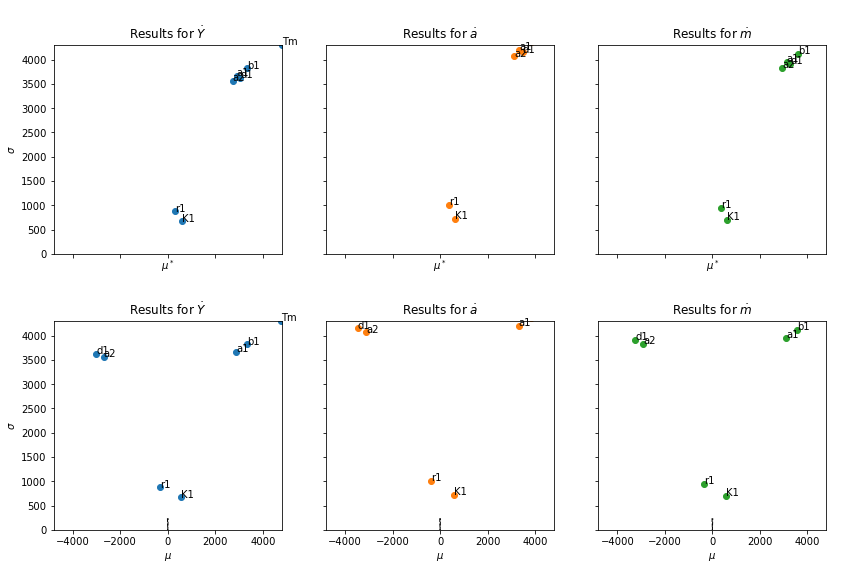

In [33]:
Siy_m3 = morris.analyze(problem_m3, param_values_m3, rss_m3[:,0])
Sia_m3 = morris.analyze(problem_m3, param_values_m3, rss_m3[:,1])
Sim_m3 = morris.analyze(problem_m3, param_values_m3, rss_m3[:,2])

labels3 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
morris_plot(Siy_m3, Sia_m3, Sim_m3, labels3)#, True, 'sens3_mu_sig.pdf')

## Third mod. of $\dot m$

### Sobol

In [34]:
#5% variation
problem4 = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[6.277, 6.938], [4.886, 5.401],[.662, .732], [.490, .542],
               [.883, .976], [3.048, 3.369],[4.194, 4.635]]
}

param_values4 = saltelli.sample(problem4, 700, calc_second_order=True)

In [35]:
rss4 = np.zeros((param_values4.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values4):
    rss4[i] = comp_rss(m_1c, t1_sc, x01, par, data1_sc[1:,:])

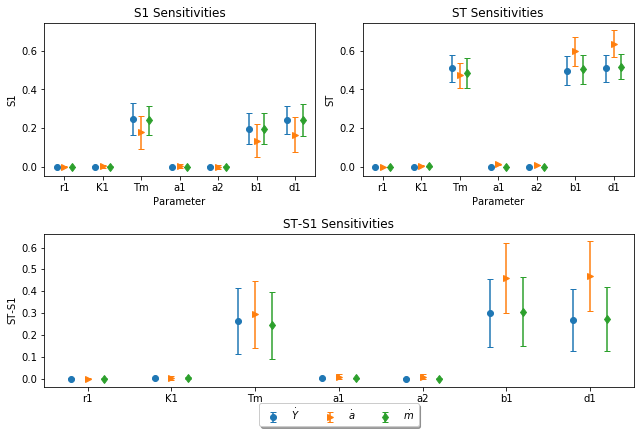

In [36]:
Siy4 = sobol.analyze(problem4, rss4[:,0], calc_second_order=True)
Sia4 = sobol.analyze(problem4, rss4[:,1], calc_second_order=True)
Sim4 = sobol.analyze(problem4, rss4[:,2], calc_second_order=True)

labels4 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
sobol_plots(Siy4, Sia4, Sim4, labels4)#, True, 'sens4_s1_st.pdf')

In [37]:
print('S2 value of Tm and b1 for Y: ' + str(Siy4['S2'][2, 5]))
print('Confidence interval for Y: ' + str(Siy4['S2_conf'][2, 5]))
print('S2 value of Tm and b1 for a: ' + str(Sia4['S2'][2, 5]))
print('Confidence interval for a: ' + str(Sia4['S2_conf'][2, 5]))
print('S2 value of Tm and b1 for m: ' + str(Sim4['S2'][2, 5]))
print('Confidence interval for m: ' + str(Sim4['S2_conf'][2, 5]))

S2 value of Tm and b1 for Y: 0.06837482083047502
Confidence interval for Y: 0.11681949314136549
S2 value of Tm and b1 for a: 0.07924865517064719
Confidence interval for a: 0.1132023476633546
S2 value of Tm and b1 for m: 0.06674280030855895
Confidence interval for m: 0.10887165907120246


In [38]:
print('S2 value of Tm and d1 for Y: ' + str(Siy4['S2'][2, 6]))
print('Confidence interval for Y: ' + str(Siy4['S2_conf'][2, 6]))
print('S2 value of Tm and d1 for a: ' + str(Sia4['S2'][2, 6]))
print('Confidence interval for a: ' + str(Sia4['S2_conf'][2, 6]))
print('S2 value of Tm and d1 for m: ' + str(Sim4['S2'][2, 6]))
print('Confidence interval for m: ' + str(Sim4['S2_conf'][2, 6]))

S2 value of Tm and d1 for Y: 0.05341922696444701
Confidence interval for Y: 0.11531416622298915
S2 value of Tm and d1 for a: 0.06389226615877244
Confidence interval for a: 0.11587699641854098
S2 value of Tm and d1 for m: 0.04857358043106061
Confidence interval for m: 0.1188312237323203


In [39]:
print('S2 value of b1 and d1 for Y: ' + str(Siy4['S2'][5, 6]))
print('Confidence interval for Y: ' + str(Siy4['S2_conf'][5, 6]))
print('S2 value of b1 and d1 for a: ' + str(Sia4['S2'][5, 6]))
print('Confidence interval for a: ' + str(Sia4['S2_conf'][5, 6]))
print('S2 value of b1 and d1 for m: ' + str(Sim4['S2'][5, 6]))
print('Confidence interval for m: ' + str(Sim4['S2_conf'][5, 6]))

S2 value of b1 and d1 for Y: 0.10374310577567464
Confidence interval for Y: 0.10607735806113236
S2 value of b1 and d1 for a: 0.2325926264371105
Confidence interval for a: 0.11726648615225747
S2 value of b1 and d1 for m: 0.12181407643136175
Confidence interval for m: 0.11460632122347594


### Morris

In [40]:
#5% variation
problem_m4 = {
    'num_vars': 7,
    'names': ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1'],
    'bounds': [[6.277, 6.938], [4.886, 5.401],[.662, .732], [.490, .542],
               [.883, .976], [3.048, 3.369],[4.194, 4.635]]
}

param_values_m4 = morris_s.sample(problem_m4, 1000, 8) 

In [41]:
rss_m4 = np.zeros((param_values_m4.shape[0],3))

x01 = [1.4180265001692174, 0.2811824057660078, 1.2673713692691995]
for i, par in enumerate(param_values_m4):
    rss_m4[i] = comp_rss(m_1c, t1_sc, x01, par, data1_sc[1:,:])

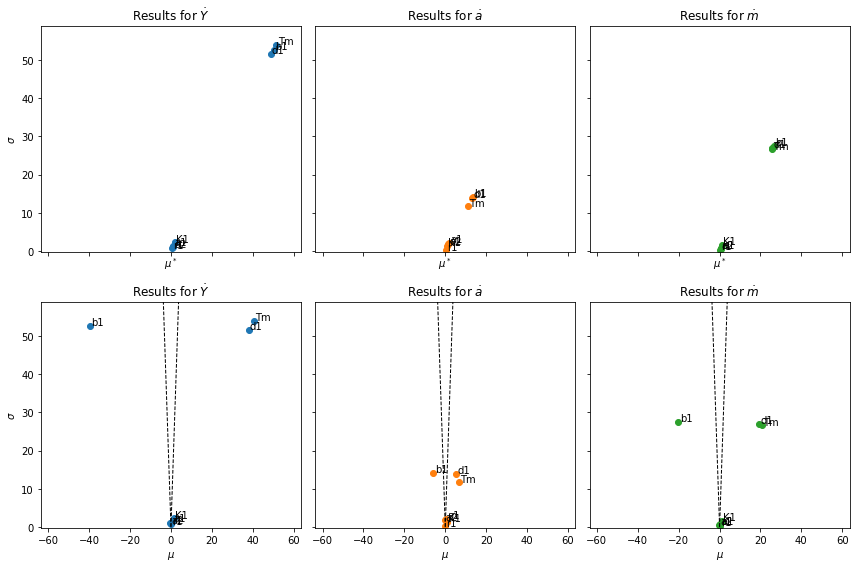

In [42]:
Siy_m4 = morris.analyze(problem_m4, param_values_m4, rss_m4[:,0])
Sia_m4 = morris.analyze(problem_m4, param_values_m4, rss_m4[:,1])
Sim_m4 = morris.analyze(problem_m4, param_values_m4, rss_m4[:,2])

labels4 = ['r1', 'K1', 'Tm', 'a1', 'a2', 'b1', 'd1']
morris_plot(Siy_m4, Sia_m4, Sim_m4, labels4)#, True, 'sens4_mu_sig.pdf')